In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vk_api
import datetime as dt
sns.set(rc = {'figure.figsize' :(16,9)})


In [2]:
token='vk1.a.Ihbrcpkc9VfNnSxZppuGVOXC-zlOem8a04NJF82J2EQ91q1vezZt6YGH5MJ98kVzrJMl8muiL9qXd-E9XjaY23eqjlg9GlXUaJvcVz8fLkJgjvXJuBUfcqtt_cqxK7gKaVn5NkbTEgcWbZjHPlCNiEbtHLYElQp2Y81QINNUbAcfgflfZCfehe4QX3Dbe3LEoQYY_JrypDHzmfzr_VllNA'

In [3]:

# Авторизация с использованием токена
vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()


    # Запрос данных о постах пользователя
def get_all_posts_info(user_id):
    posts_info = []
    offset = 0
    count_per_request = 100

    while True:
        response = vk.wall.get(owner_id=user_id, count=count_per_request, offset=offset)

        if not response['items']:
            break

        for post in response['items']:
            post_date = post['date']
            likes_count = post['likes']['count']
            posts_info.append({'date': post_date, 'likes': likes_count})

        offset += count_per_request

    return posts_info



In [4]:
posts = get_all_posts_info('544416')

In [5]:
df = pd.DataFrame(posts)

In [6]:
df['date']  = pd.to_datetime(df.date,unit = 's')

In [7]:
df.head()

,date,likes
0,2023-07-31 07:21:48,1
1,2023-04-20 05:06:40,14
2,2022-12-15 07:33:40,29
3,2022-12-14 18:28:08,38
4,2022-10-03 19:40:12,18


In [8]:
df.to_csv('posts.csv',index=False)

Возьмите свою страницу Вконтакте, соберите по ней таблицу с датой постов и количеством лайков и напишите SQL-запросы, которые позволят ответить на вопрос: что больше всего влияет на количество лайков: время суток публикации, день недели или промежуток между постами.

Добавим в датафрейм столбец время суток:утро - 06:12, день - 12-18, вечер - 18-00, ночь 00-06.

Добавим в датафрейм столбец день недели

Добавим столбец, в который занесем разницу по времени с предыдущим постом, выраженную в часах

In [16]:
df['day_part'] = pd.cut(df.date.dt.hour,4,labels = ['night','morning','day','evening',])
df['weekday'] = df.date.dt.day_name()
df["lag"] =(df.date - df.date.shift(-1)).astype('timedelta64[D]')

In [17]:
df

,date,likes,day_part,weekday,lag
0,2023-07-31 07:21:48,1,morning,Monday,102.0
1,2023-04-20 05:06:40,14,night,Thursday,125.0
2,2022-12-15 07:33:40,29,morning,Thursday,0.0
3,2022-12-14 18:28:08,38,evening,Wednesday,71.0
4,2022-10-03 19:40:12,18,evening,Monday,180.0
...,...,...,...,...,...
1042,2013-07-09 18:36:48,5,evening,Tuesday,0.0
1043,2013-07-09 15:37:05,2,day,Tuesday,0.0
1044,2013-07-09 08:05:52,1,morning,Tuesday,0.0
1045,2013-07-08 21:29:47,2,evening,Monday,15.0


In [18]:
week_like  = df.groupby('weekday', as_index = False).agg({'likes':'mean'})

In [24]:
np.round((week_like.likes.max() - week_like.likes.min())/week_like.likes.max()*100,2)

34.59

In [11]:
day_part = df.groupby('day_part', as_index = False).agg({'likes':'mean'})

In [12]:
day_part

,day_part,likes
0,night,14.705882
1,morning,17.000000
2,day,16.254438
3,evening,24.043478


In [13]:
np.round((day_part.likes.max() - day_part.likes.min())/day_part.likes.max()*100,2)

38.84

In [18]:
dayz = df.groupby('lag', as_index = False).agg({'likes':'mean'})

In [19]:
dayz

,lag,likes
0,0.0,17.822967
1,1.0,15.722222
2,2.0,20.797619
3,3.0,21.000000
4,4.0,27.920000
5,5.0,19.947368
6,6.0,29.600000
7,7.0,17.083333
8,8.0,22.500000
9,9.0,22.600000


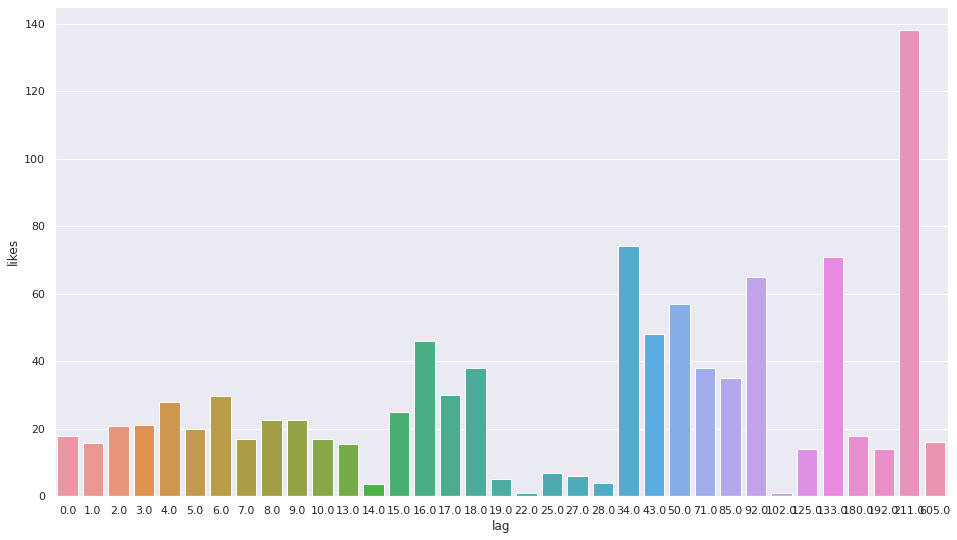

In [21]:
sns.barplot(data = dayz, x = 'lag',y = 'likes')

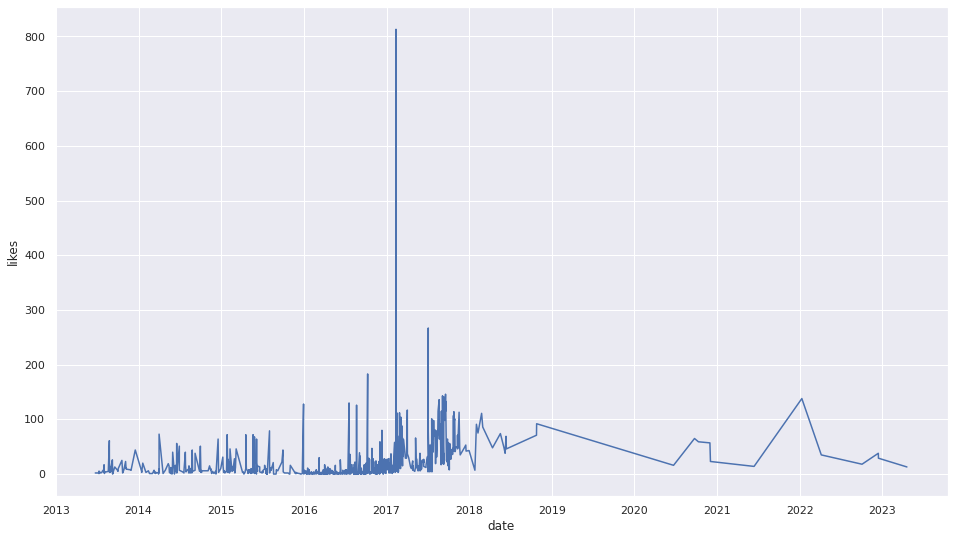

In [104]:
sns.lineplot(data = df, x = 'date',y = 'likes')

In [107]:
df.loc[df.likes == df.likes.max()]

,date,likes
245,2017-02-11 23:35:38,813
